In [11]:
# Developed by Samuel Horovatin at the University of Saskatchewan
# July, 2021
from plantcv import plantcv as pcv
import matplotlib.pyplot as plt
import os
import os.path
import shutil
import pandas as pd
import numpy as np
from numpy import load
import random
from datetime import date

from skimage.transform import resize
from skimage.io import imread
from skimage.io import imshow
from skimage import filters
from sklearn.cluster import KMeans
import cv2
import pickle

In [2]:
# Base paramaters used by plantcv for image discovery and processing

plt.rcParams["figure.figsize"] = [8, 8]
class options:
    def __init__(self):
        # Input image path/filename
        self.datastore_base_dir = "/datastore/AGILE/BELToutput/LDP_Sebastian"
        self.extention_pattern = ".npz"
        # Debug mode = None, "plot", or "print"
        self.debug = "plot" #DO NOT SET TO PLOT FOR BIG DATA RUNS.
        # Store output images (True/False)
        self.writeimg = False
        # Results path/filename
        self.result = "results.txt"
        # Image output directory path
        self.outdir = "/birl2/users/sch923/Thesis/Lentil/output"

# Initialize options
args = options()
# Set PlantCV debug mode to input debug method
pcv.params.debug = args.debug
# Increase text size in plots
pcv.params.text_size = 20
pcv.params.text_thickness = 10

In [3]:
# Searches for all files with certain pattern in datastore_base_dir

files = []
for dirpath, dirnames, filenames in os.walk(args.datastore_base_dir):
    for filename in [f for f in filenames if f.endswith(args.extention_pattern)]:
        files.append(os.path.join(dirpath, filename))

print(f"=== Found ({len(files)}) files of pattern {args.extention_pattern} ===")

=== Found (1068353) files of pattern .npz ===


In [9]:
# Pickle step to save time loading files
with open(f'file_path_list_{args.extention_pattern}_{date.today().strftime("%d_%m_%Y")}.pkl', 'wb') as f:
    pickle.dump(files, f)

In [19]:
# FOR TESTING

IMG_X = 300
IMG_Y = 300
IMG_Z = 3
FILE_LIMITER = 5 # Only used for manual testing in for loop
i = 0

lentil_images=[]
lentil_images_names=[]
image_ROIs=[]

lentil_img_path = random.sample(files, FILE_LIMITER)
img = load(lentil_img_path[0])
print(img.files)

['front_lab', 'front_mask', 'side_mask', 'height_scaling_position']


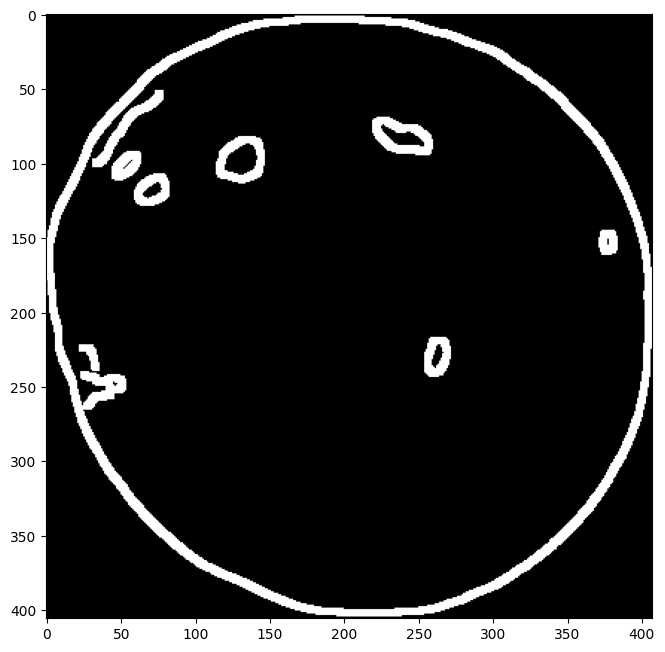

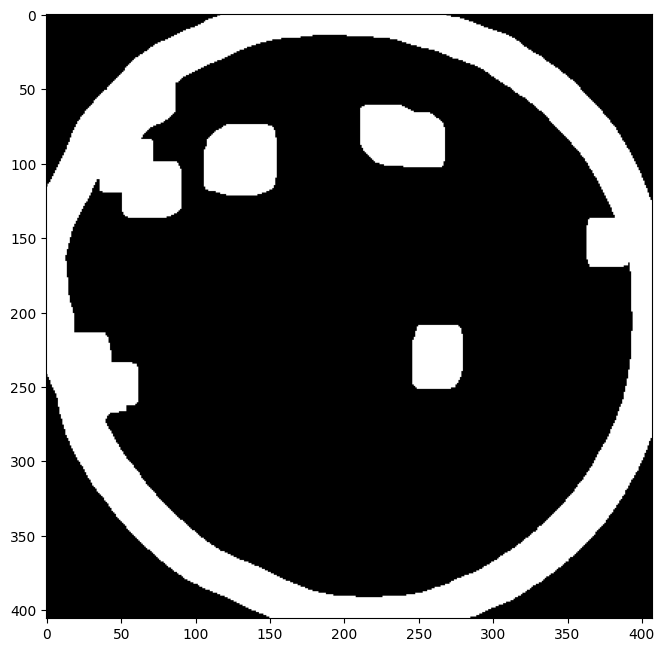

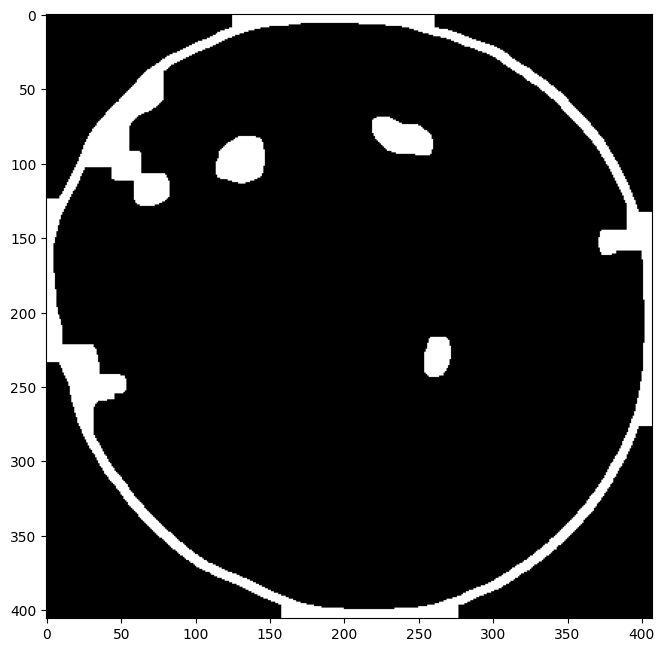

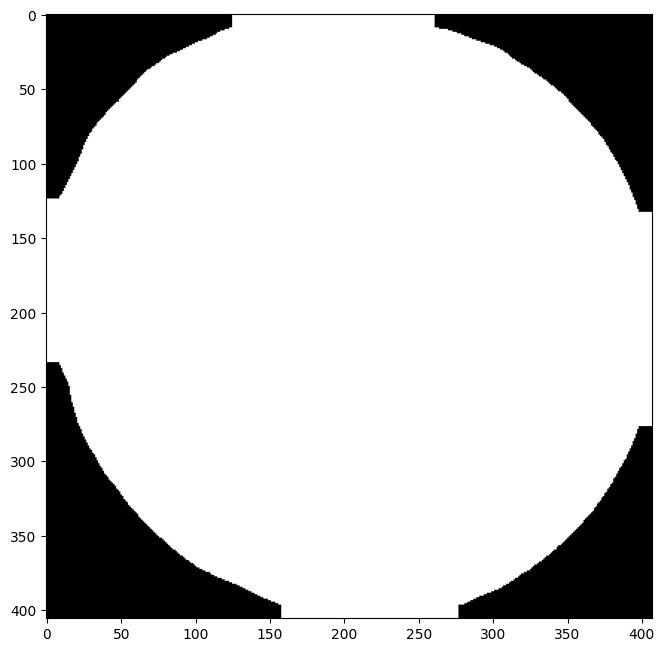

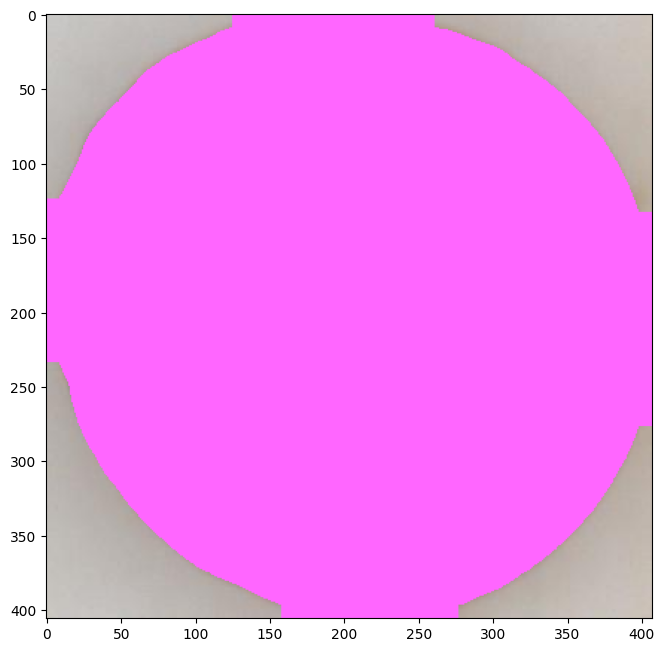

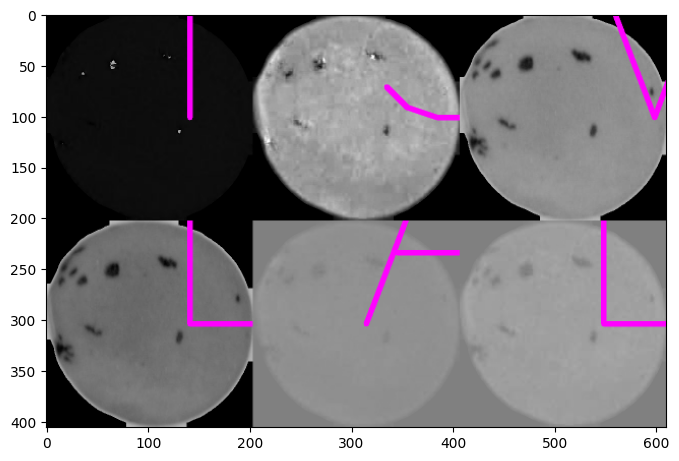

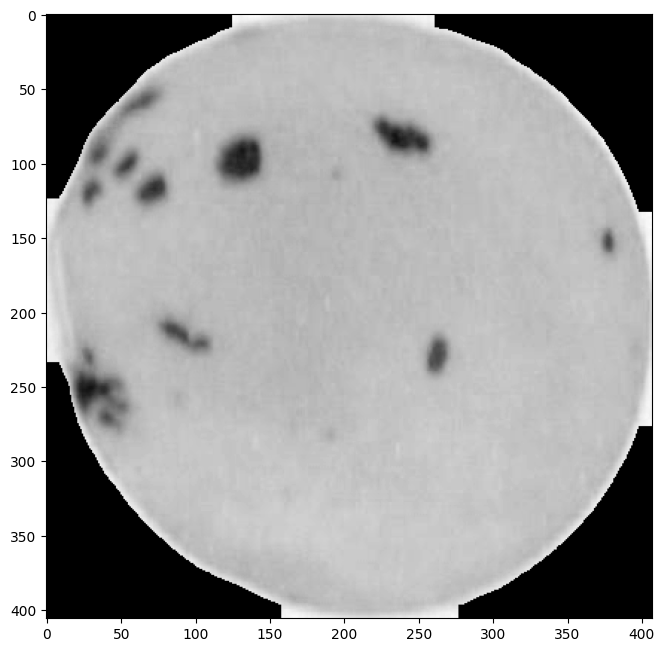

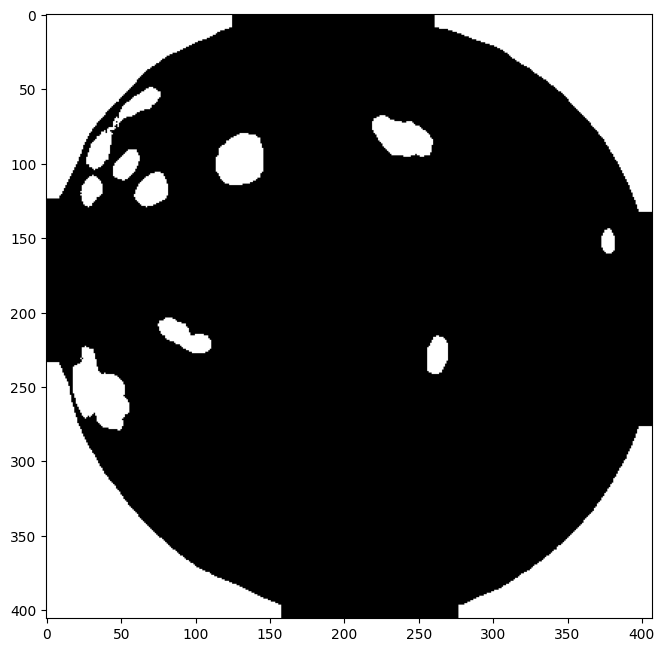

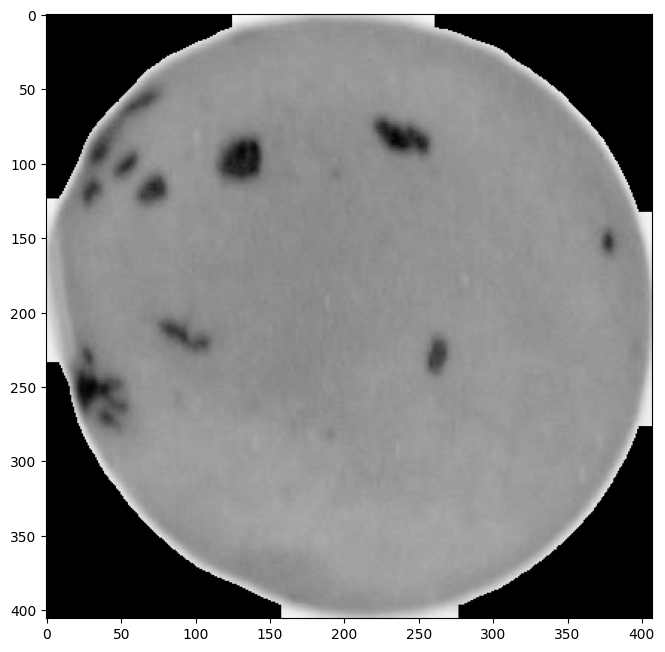

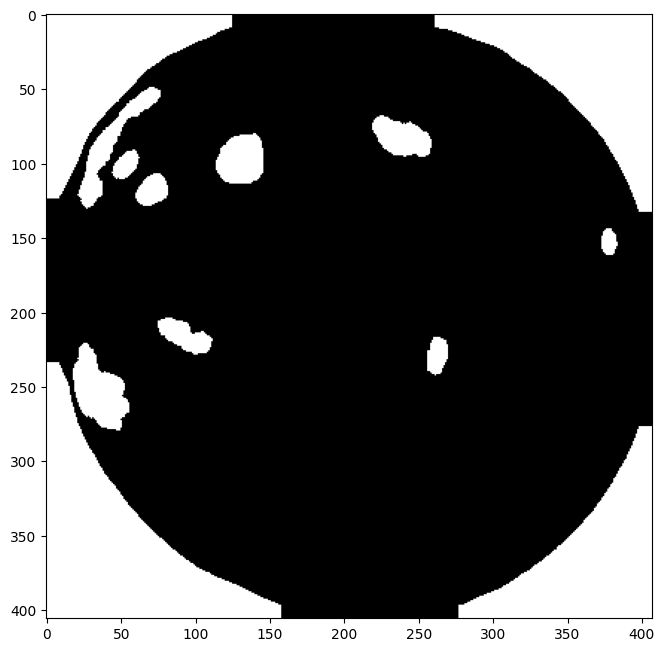

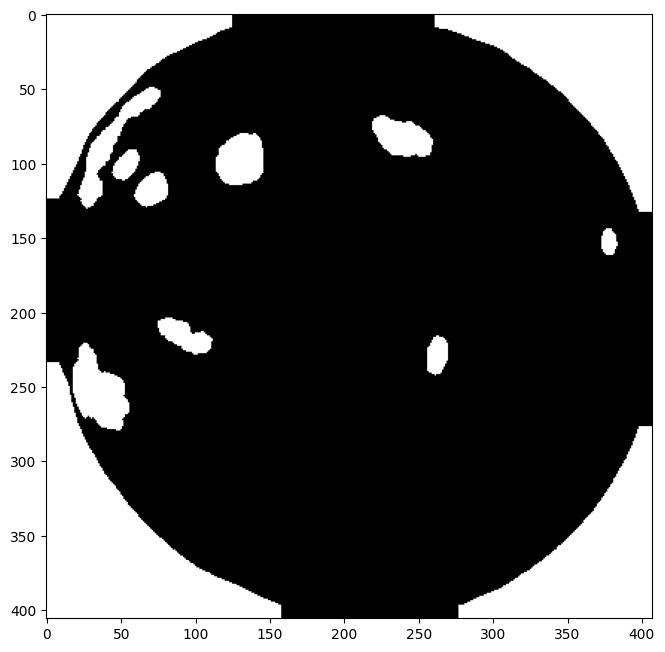

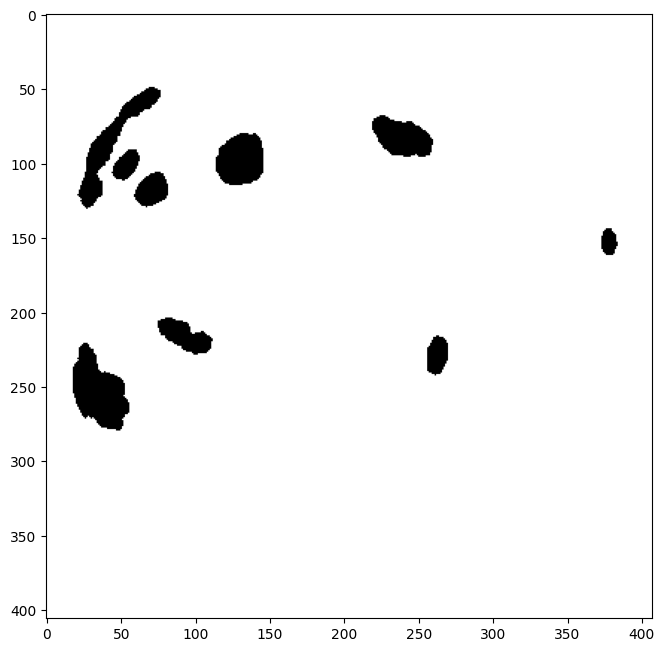

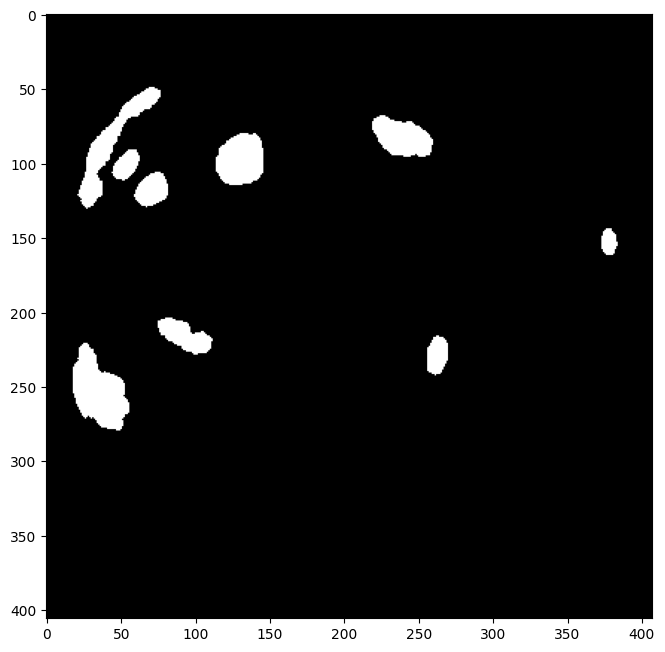

In [44]:
# FOR TESTING

# Segmentation of lentil for color averaging
edges = pcv.canny_edge_detect(img=img, sigma=2.0, low_thresh=0.5, thickness=5)
dilate = pcv.dilate(gray_img=edges, ksize=9, i=2)
erode = pcv.erode(gray_img=dilate, ksize=9, i=2)
mask = pcv.fill_holes(erode)

# Used to filter out incorrectly traced ROI
if np.average(mask) < 150.0:
    print(f"Error in ROI Tracing: {lentil_img_path}")
    # continue
id_objects, obj_hierarchy = pcv.find_objects(img=img, mask=mask)
(x, y, w, h) = cv2.boundingRect(id_objects[0])
image_ROI = img[y:y + h, x:x + w]
mask_ROI = mask[y:y + h, x:x + w]
bound_img = cv2.bitwise_and(image_ROI, image_ROI, mask=mask_ROI)

# Color analysis and averaging
cs_plot = pcv.visualize.colorspaces(rgb_img=bound_img, original_img=False)
v = pcv.rgb2gray_hsv(rgb_img=bound_img, channel='v')
v_thresh = pcv.threshold.binary(gray_img=v, threshold=np.average(v), max_value=255, object_type='dark')
l = pcv.rgb2gray_lab(rgb_img=bound_img, channel='l')
l_thresh = pcv.threshold.binary(gray_img=l, threshold=np.average(l), max_value=255, object_type='dark')
vl = pcv.logical_or(bin_img1=v_thresh, bin_img2=l_thresh)
vl_bless = pcv.logical_xor(bin_img1=mask_ROI, bin_img2=vl)
vl_bless_inv = pcv.invert(vl_bless)
img_resized=resize(vl_bless_inv,(IMG_X, IMG_Y, IMG_Z))

In [8]:
# Bulk proccesses all found images, flattens them, and loads them int array for training

IMG_X = 300
IMG_Y = 300
IMG_Z = 3
FILE_LIMITER = 5000 # Only used for manual testing in for loop
i = 0

lentil_images=[]
lentil_images_names=[]
image_ROIs=[]

for lentil_img_path in random.sample(files, FILE_LIMITER):
    
    try:
        img, lentil_img_path, filename = pcv.readimage(filename=lentil_img_path)
        
    except:
        print(f"Error opening file: {os.path.join(lentil_img_path, filename)}")
        continue
    
    # Segmentation of lentil for color averaging
    edges = pcv.canny_edge_detect(img=img, sigma=2.0, low_thresh=0.5, thickness=5)
    dilate = pcv.dilate(gray_img=edges, ksize=9, i=2)
    erode = pcv.erode(gray_img=dilate, ksize=9, i=2)
    
    # Used to filter out incorrectly traced ROI
    try:
        mask = pcv.fill_holes(erode)
        if np.average(mask) < 150.0:
            print(f"Error in ROI Tracing: {os.path.join(lentil_img_path, filename)}")
            continue
    except:
        print(f"Error in ROI Tracing: {os.path.join(lentil_img_path, filename)}")
        continue
           
    id_objects, _ = pcv.find_objects(img=img, mask=mask)
    (x, y, w, h) = cv2.boundingRect(id_objects[0])
    image_ROI = img[y:y + h, x:x + w]
    mask_ROI = mask[y:y + h, x:x + w]
    bound_img = cv2.bitwise_and(image_ROI, image_ROI, mask=mask_ROI)

    # Color analysis and averaging
    # cs_plot = pcv.visualize.colorspaces(rgb_img=bound_img, original_img=False) # for testing only
    v = pcv.rgb2gray_hsv(rgb_img=bound_img, channel='v')
    v_thresh = pcv.threshold.binary(gray_img=v, threshold=np.average(v), max_value=255, object_type='dark')
    l = pcv.rgb2gray_lab(rgb_img=bound_img, channel='l')
    l_thresh = pcv.threshold.binary(gray_img=l, threshold=np.average(l), max_value=255, object_type='dark')
    vl = pcv.logical_or(bin_img1=v_thresh, bin_img2=l_thresh)
    vl_bless = pcv.logical_xor(bin_img1=vl, bin_img2=mask_ROI)
    vl_bless_inv = pcv.invert(vl_bless)
    img_resized=resize(vl_bless_inv,(IMG_X, IMG_Y, IMG_Z))
    
    
    lentil_images.append(img_resized.flatten())
    lentil_images_names.append(os.path.join(lentil_img_path, filename))
 
print(f"Loaded ({len(lentil_images)}) image files")

Error in ROI Tracing: /datastore/AGILE/BELToutput/LDP_Sebastian/Experiment 2/31.5.2021/319_6475_rep2_ros/thumbnails/16401081_112.jpg
Error in ROI Tracing: /datastore/AGILE/BELToutput/LDP_Sebastian/Experiment 2/17.3.2021/106_6524_rep2_ros/thumbnails/16401081_210.jpg
Error in ROI Tracing: /datastore/AGILE/BELToutput/LDP_Sebastian/Sutherland 2017/11 suth 2017/181_5654_rep2_suth/thumbnails/16401081_68.jpg
Error in ROI Tracing: /datastore/AGILE/BELToutput/LDP_Sebastian/Experiment 2/27.04.2021/167_5428_rep2_suth/thumbnails/16401081_267.jpg
Error in ROI Tracing: /datastore/AGILE/BELToutput/LDP_Sebastian/Experiment 2/2.8.2021/91_2091_rep1_spa/thumbnails/16401081_136.jpg
Error in ROI Tracing: /datastore/AGILE/BELToutput/LDP_Sebastian/Experiment 2/30.4.2021/180_6481_rep2_ros/thumbnails/16401081_6.jpg
Error in ROI Tracing: /datastore/AGILE/BELToutput/LDP_Sebastian/Experiment 2/redone 6/29.4.2021/178_6741_rep2_ros/thumbnails/16401081_84.jpg
Error in ROI Tracing: /datastore/AGILE/BELToutput/LDP_Seb

In [9]:
# Trains n number of k-mean models, with increment of n = k of the model

kMax = min(10, len(lentil_images))
kMin = 2 # Having K = 1 is a waste of time
lentil_kmean_models = []
wcss = [] # For 'within cluster sum of squares' calcuation, which is used to guage correct K value.
# Fits KMean to data using multiple values for K
for k in range(kMin, kMax):
    print(f"========= Training k={k}... =========")
    model = KMeans(n_clusters=k, random_state=0)
    model.fit(lentil_images)
    wcss.append(model.inertia_)
    lentil_kmean_models.append(model)

print(f"========= Training Complete! K-Means Models Trained = {kMax-kMin}... =========")    

========= Training k=2... =========
========= Training k=3... =========
========= Training k=4... =========
========= Training k=5... =========
========= Training k=6... =========
========= Training k=7... =========
========= Training k=8... =========
========= Training k=9... =========
========= Training Complete! K-Means Models Trained = 8... =========


In [ ]:
# Trains n number of k-mean models, with increment of n = k of the model

kMax = min(10, len(lentil_images))
kMin = 2 # Having K = 1 is a waste of time
lentil_kmean_models = []
wcss = [] # For 'within cluster sum of squares' calcuation, which is used to guage correct K value.
# Fits KMean to data using multiple values for K
for k in range(kMin, kMax):
    print(f"========= Training k={k}... =========")
    model = KMeans(n_clusters=k, random_state=0)
    model.fit(lentil_images)
    wcss.append(model.inertia_)
    lentil_kmean_models.append(model)

print(f"========= Training Complete! K-Means Models Trained = {kMax-kMin}... =========")    

========= Training k=2... =========
========= Training k=3... =========
========= Training k=4... =========
========= Training k=5... =========
========= Training k=6... =========
========= Training k=7... =========
========= Training k=8... =========
========= Training k=9... =========
========= Training Complete! K-Means Models Trained = 8... =========


In [ ]:
# Trains t-SNE models


In [10]:
k = kMin
prediction_df = pd.DataFrame(columns=['img', 'k', 'group_pred']) 

for model in lentil_kmean_models:
    model_pred = model.predict(lentil_images)
    for name, pred in zip(lentil_images_names, model_pred):
        prediction_df = prediction_df.append({'img': name, 'k': k, 'group_pred': pred }, ignore_index=True)
    k = k + 1

prediction_df.to_csv("pattern_5000_new.csv", encoding='utf-8', sep=',', index=False)

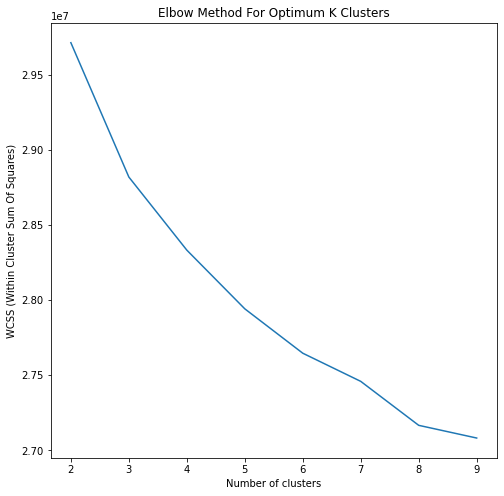

In [11]:
# Produces wcss graph for evaluation of appropriate value of K
# https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203

plt.plot(range(kMin, kMax), wcss)
plt.title('Elbow Method For Optimum K Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Within Cluster Sum Of Squares)')
plt.show()